# Libraries

In [1]:
import sys
dabs_ms_dir = r"DABS-MS-Network"
sys.path.append(dabs_ms_dir)

import numpy as np
import torch
from learner import Learner
import random
import os
import pickle
import matplotlib.pyplot as plt

#this should seed them globally to reduce variability
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
pass

# Data Preprocessing and Structure
### Preprocessing
DABS-MS expects that
- All the training/validation/testing images are affinely registered to the atlas image.
- The dimension and voxel size is constant in all 3 dimensions, though the actual value is configurable.
- The training/validation/testing/gt images are raw image files written with a byte order of 'F' (Fortran-style order), with a float32/single datatype
- The atlas image has a corresponding mask, mesh, and distance map
  - The image, mask, and distance map should be .nrrd files
  - The mesh is a Mesh class, defined in DABS-MS-Network/parser.py
- All the masks (atlas/gt) are binary masks with black = 0 and white = 255
- All the images are scaled such that the min is around 0 and the max is around 1 (doesn't have to be exact)
  - If there is any "out of bounds" areas that happen due to the affine registration and cropping issues, fill them in with the mean value of the rest of the image
  
DABS-MS has the following optional inputs
- For each case, if there's an area in of the image that you want excluded from the metrics, you can supply Out-Of-Bounds (oob) masks to indicate that area
- For the MS term, if you'd like to use a different atlas mask than you're using for evaluation and the weighted gradient term, you can supply it as well using the path_params/ms_atlas_filename section of the parameter dictionary

### File Structure
DABS-MS expects that each training/validation/testing case has a unique patient ID, also called a "keyword". It expects that there's a file where the keywords are listed, in three sections separated by double newlines, for training/validation/testing respectively. For example:

train_keyword1<br>
train_keyword2<br>
train_keyword3<br>

valid_keyword1<br>
valid_keyword2<br>
valid_keyword3<br>

test_keyword1<br>
test_keyword2<br>
test_keyword3<br>

It also expects that there's an image directory, ground truth directory, and (optionally) a out-of-bounds directory, with files following a consistent structure. These structures can be defined in the img_template, gt_template, and oob_template sections of the parameter dictionary.

# Parameter Dictionary

In [2]:
data_dir = r"D:\Project_Data\DATA"
dataset = "sKiTS21"
dataset_dir = os.path.join(data_dir, dataset)

params = {}

params["training_params"] = {}
params["training_params"]["batch_size"] = 5
params["training_params"]["epochs"] = 200
params["training_params"]["dim"] = (64, 64, 64)
params["training_params"]["sz"] = (0.3, 0.3, 0.3)
params["training_params"]["device"] = "cuda"

params["path_params"] = {}
params["path_params"]["keyword_filename"]        = r"%s\info\keywords.txt" % dataset_dir #a list of all patient IDs, separated into training, validation, and testing chunks by double newlines
params["path_params"]["progress_dir"]            = "output_%s" % dataset

#these are the paths for the data, where %s will get replaced with the patient ID
params["path_params"]["img_dir"]                 = r"%s\img_mean" % dataset_dir #where the images are
params["path_params"]["gt_dir"]                  = r"%s\gt" % dataset_dir #where the ground truth is
if dataset == "IAC":
    params["path_params"]["oob_dir"]                  = r"%s\oob" % dataset_dir #Out-of-bounds masks for the ground truths: not every dataset will have this, can leave blank
else:
    params["path_params"]["oob_dir"]                  = ""
params["path_params"]["img_template"]            = "%s_scaled_mean_filled_img.im" #how the image filenames are formatted in the image dir
params["path_params"]["gt_template"]            = "%s_standardized_msk.im" #how the gt filenames are formatted
params["path_params"]["oob_template"]            = "%s_oob_mask.im" #how the oob filenames are formatted
#atlas
params["path_params"]["atlas_im_filename"]       = r"%s\atlas\atlas_scaled_mean_filled_img.nrrd" % dataset_dir #the atlas CT image
params["path_params"]["atlas_mesh_filename"]     = r"%s\atlas\atlas_standardized_mesh.mesh" % dataset_dir #the atlas mesh
params["path_params"]["atlas_mask_filename"]     = r"%s\atlas\atlas_standardized_msk.nrrd" % dataset_dir #the atlas mask
if dataset == "IAC":
    params["path_params"]["ms_atlas_filename"]       = r"%s\atlas\levelset_atlas_mask.nrrd" % dataset_dir #if using a modified atlas mask for the mumford shah term, put the filename here. else make an empty string
else:
    params["path_params"]["ms_atlas_filename"]       = ""
params["path_params"]["atlas_dist_filename"]     = r"%s\atlas\atlas_standardized_dst.nrrd" % dataset_dir #a distance transform of the atlas in mm

#losses
params["losses"] = {}
params["losses"]["cross_correlation"] = {"filename":"losses.cross_correlation_loss", "weight": 1.0}
params["losses"]["gradient"]          = {"filename":"losses.gradient_loss",          "weight": 0.0} #recommended: don't use both gradients at the same time
params["losses"]["weighted_gradient"] = {"filename":"losses.weighted_gradient_loss", "weight": 2.0}
params["losses"]["mumford_shah"]      = {"filename":"losses.mumford_shah_loss",      "weight": 0.5}

#debug
params["debug_params"] = {}
params["debug_params"]["verbose"] = False

# Use the Learner
**The "learner" is an object which handles all of the network's training, testing, etc. The goal is to separate the "input" and "processing" as much as possible, for maximal versatility**

In [3]:
lrnr = Learner(params, "DABS-MS-Example", verbose_learner = True)

Loading parameters...
Making destination directories...
Loading global values...
Loading model...
Making dataloaders...


**It has a built in train function...**

Starting training...
Epoch 1/200:
Epoch:  1 , train: 0.40769716245787485 , valid: 0.3882042467594147
Saving model...
	completed in 10.358830213546753 seconds
Epoch 2/200:
Epoch:  2 , train: 0.3895488679409027 , valid: 0.37092071274916333
Saving model...
	completed in 7.109432697296143 seconds
Epoch 3/200:
Epoch:  3 , train: 0.3764561911424001 , valid: 0.35740022857983905
Saving model...
	completed in 7.285848617553711 seconds
Epoch 4/200:
Epoch:  4 , train: 0.363785730940955 , valid: 0.3460085342327754
Saving model...
	completed in 7.1359639167785645 seconds
Epoch 5/200:
Epoch:  5 , train: 0.3566345728579022 , valid: 0.34061912447214127
Saving model...
	completed in 7.390697240829468 seconds
Epoch 6/200:
Epoch:  6 , train: 0.3488017547698248 , valid: 0.3350440139571826
Saving model...
	completed in 7.3593175411224365 seconds
Epoch 7/200:
Epoch:  7 , train: 0.3431751713866279 , valid: 0.32939036438862485
Saving model...
	completed in 7.31269907951355 seconds
Epoch 8/200:
Epoch:  8 , tra

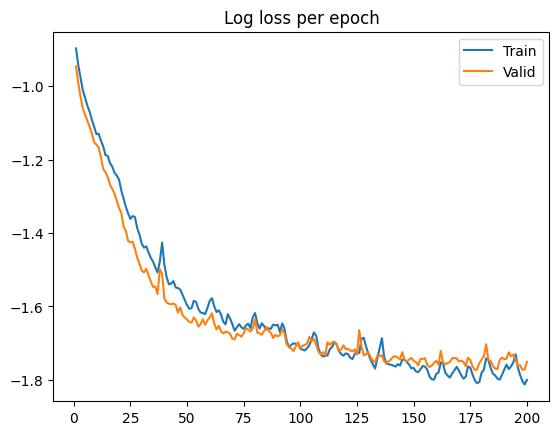

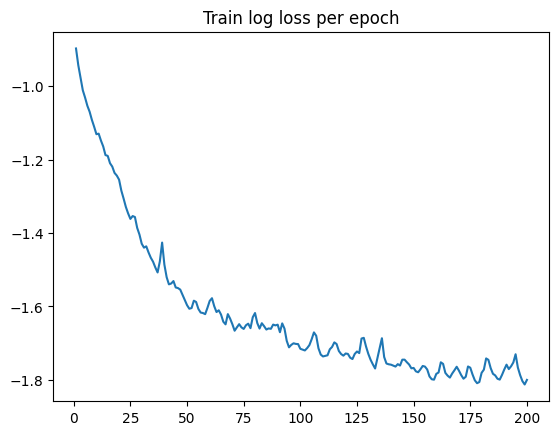

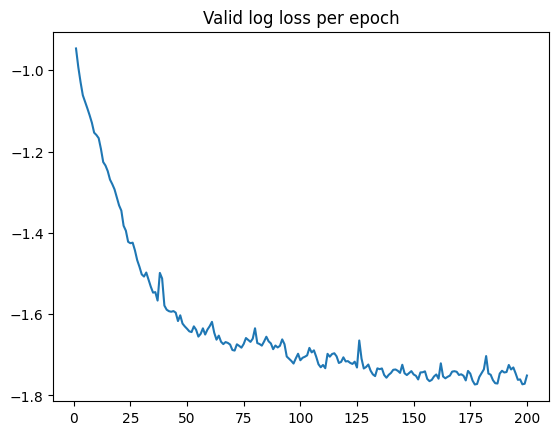

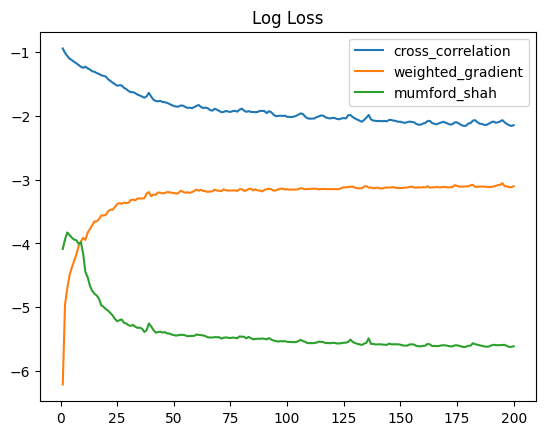

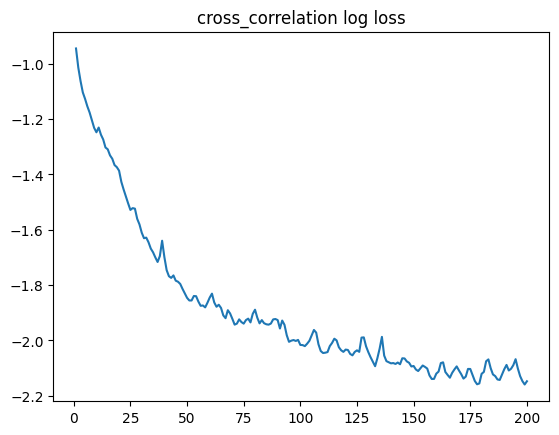

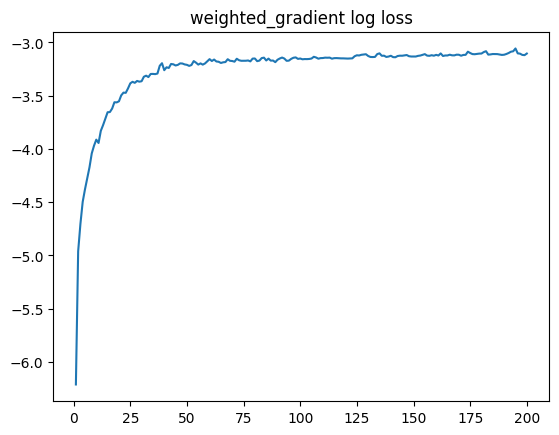

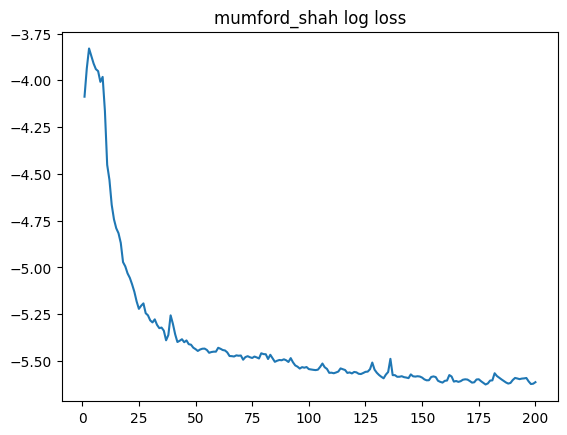

In [4]:
lrnr.train()

**The export function saves all of the deformation fields for the validation and test cases**

In [5]:
lrnr.export(include_valid = False)

Testing batch 1 of 12 | Loss: 0.17563050985336304
Testing batch 2 of 12 | Loss: 0.16162702441215515
Testing batch 3 of 12 | Loss: 0.1652325689792633
Testing batch 4 of 12 | Loss: 0.25833237171173096
Testing batch 5 of 12 | Loss: 0.1991281360387802
Testing batch 6 of 12 | Loss: 0.17619816958904266
Testing batch 7 of 12 | Loss: 0.1453372687101364
Testing batch 8 of 12 | Loss: 0.23992091417312622
Testing batch 9 of 12 | Loss: 0.15592306852340698
Testing batch 10 of 12 | Loss: 0.22014601528644562
Testing batch 11 of 12 | Loss: 0.14635439217090607
Testing batch 12 of 12 | Loss: 0.2347523272037506


**The evaluate function finds the Dice score and 95th Percentile Hausdorff distance (95HD) of each case, saving the results in pickled dictionary for later reference**

In [6]:
lrnr.evaluate(include_valid = False)

# Plot the results

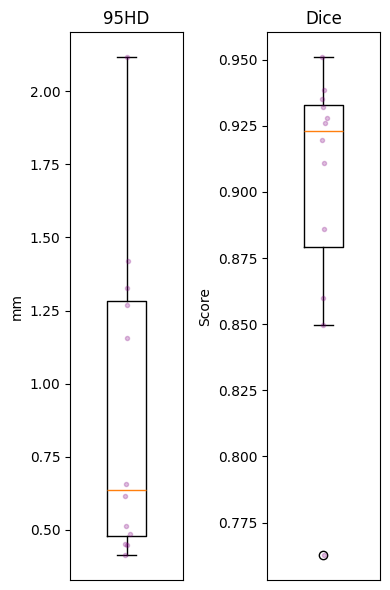

In [7]:
with open(os.path.join(lrnr.progress_dir, "results.pkl"), "rb") as file:
    results = pickle.load(file)

def noble_boxplot(D):
    bp = plt.boxplot(D, widths=0.35)
    sf = .1 * (1 - np.exp(-np.shape(D)[1] / 4))
    d_bin = np.zeros(np.shape(D)[0], dtype=int)
    
    for i in range(np.shape(D)[1]):
        h, x = np.histogram(D[:, i], bins=10)
        h = h / np.amax(h) if np.amax(h) > 0 else h
        for j in range(np.shape(D)[0]):
            bin = np.nonzero(D[j, i] < x)
            if np.size(bin) > 0:
                d_bin[j] = bin[0][0] - 1
            else:
                d_bin[j] = np.size(x) - 2

        dx = np.random.default_rng(0).normal(size=np.shape(D)[0]) * sf * h[d_bin]
        msk = np.abs(dx) > sf * 2
        dx[msk] = 2 * sf * dx[msk] / np.abs(dx[msk])

        plt.plot(dx + i + 1, D[:, i], '.', color="purple", alpha=.25)
        
plt.figure(figsize = (4, 6))
plt.subplot(121)
plt.title("95HD")
noble_boxplot(np.expand_dims(results['test']['dist_95s'], axis = 1))
plt.ylabel("mm")
plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(122)
plt.title("Dice")
noble_boxplot(np.expand_dims(results['test']['dice_scores'], axis = 1))
plt.ylabel("Score")
plt.gca().axes.get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()